# Fitting Gaussians to a bimodal distribution
The  aim of this exercise is to use Gaussian mixture model to learn the parameters of a distribution, so as to use it to resolve our distribution into component. My approach has been:
* to use GMM to learn the underlining probability distribution function and then generate random data base on the learnt distribution
* then i use the generated data to fit clusters to the distribution, which should return the mean and covariance of each cluster
* using the obtained mean and covariances, i now proceed to fit my data

## About the data
My data is made up of the weight of some species on the  x-axis and their count (frequency) on the y-axis

## The problem I am facing
When I compare the output of my attempt using GMM to just using softwares like origine to fit the peak, mine is clearly not right

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from scipy.optimize import curve_fit
speciesData = pd.read_excel('data.xlsx')
speciesData.head()


,species,count
0,6.56574,0.001792
1,6.53772,0.005567
2,6.50975,0.006549
3,6.48185,0.009137
4,6.45401,0.009579


##### A look at the underlining distribution

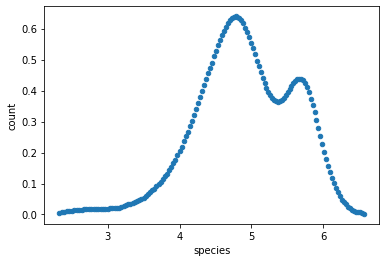

In [118]:
speciesData.plot(x='species',y='count',kind='scatter')
plt.show()

##### resolving of the peaks using origine software
I aim to at least have something close to the picture below

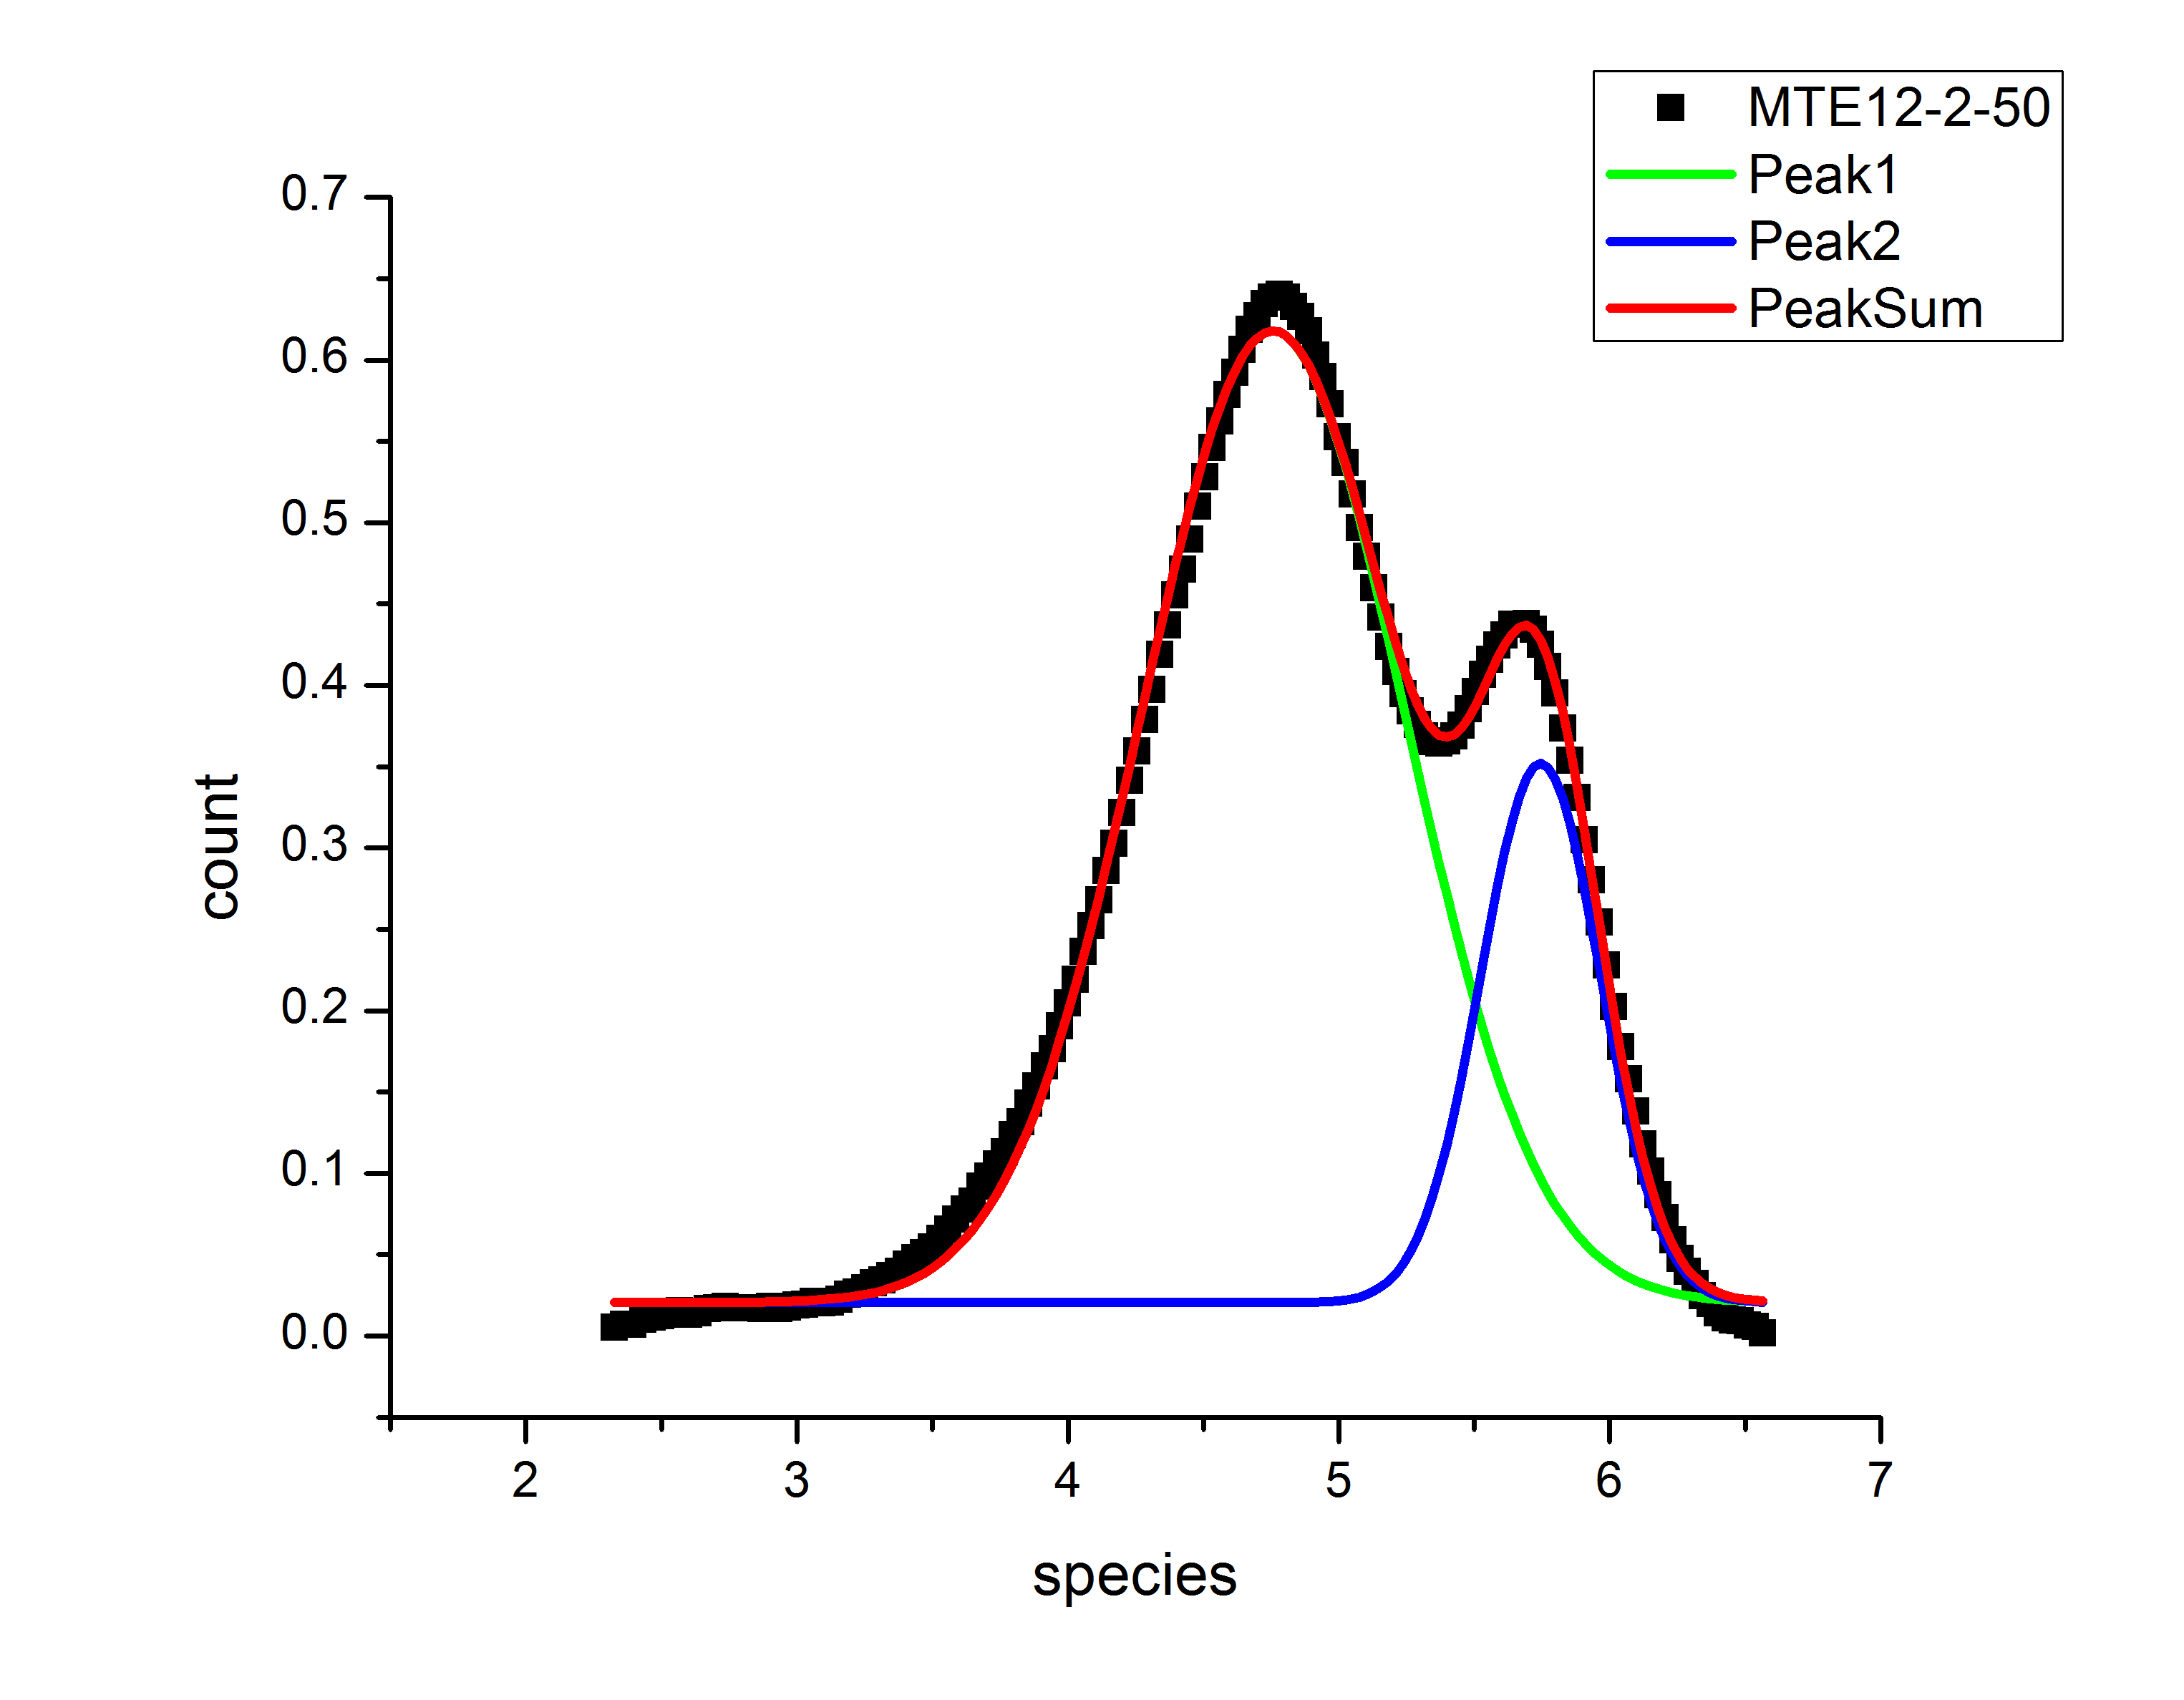

In [119]:
from IPython.display import Image
Image('origineplot.png',width=400,height=400)

### My approach
#### Defining the number of clusters
defining the number of clusters to fit using the mixture model.  A comparison between 2 and 3 clusters
##### GMM function

In [120]:
# defining the number of clusters using mixture model
def gmmClustering(rawdata,gausComponents):
    """ Perform clustering on data
    
    arg:
    * rawdata(array): the data on the species
    * gausComponents(int): the number of clusters to fit
    
    returns:
    * a list with: the weight of the cluster, the mean and the  standard deviation for each cluster
    """
    gmm =GaussianMixture(n_components=gausComponents, covariance_type='full').fit(rawdata) 
    mean = gmm.means_[:,0]
    covariance = gmm.covariances_
    weight = gmm.weights_
    parameters =[]
    for i in range(gausComponents):
        parameters.append([weight[i],mean[i],np.sqrt(np.diag(covariance[i]))[0]])
    return list(np.hstack(parameters))



##### fitting 2 and 3 clusters

In [121]:
# fitting 2 and 3 clusters to our distribution
x = speciesData.iloc[:,0].dropna().values
y = speciesData.iloc[:,1].dropna().values
fit2cluster = gmmClustering(speciesData.dropna().values,2)
fit3cluster = gmmClustering(speciesData.dropna().values,3)


### Approach 1
#### Using a Gaussian function to plot directly the learnt parameters from the GMM
The weight, mean and standard deviations from the Gmm are used directly to plot the gaussians

In [122]:
# Gaussians
def _1gaussian(x_array, amp,cen,sigma):
    """ Generate a Gaussian distribution given distribution parameters
    args:
        *x-values(array): the values of the x-axis
        * amp(float): amplitude of the distribution
        *cen(float): mean of the distribution
        *sigma(float): the standard deviation  of distribution
    return:
        y(list): fitted values for the gaussian"""
    return amp*(np.exp(-(x_array-cen)**2/(2*sigma**2)))



### Visualizing the GMM output for a 2 and 3 cluster fit

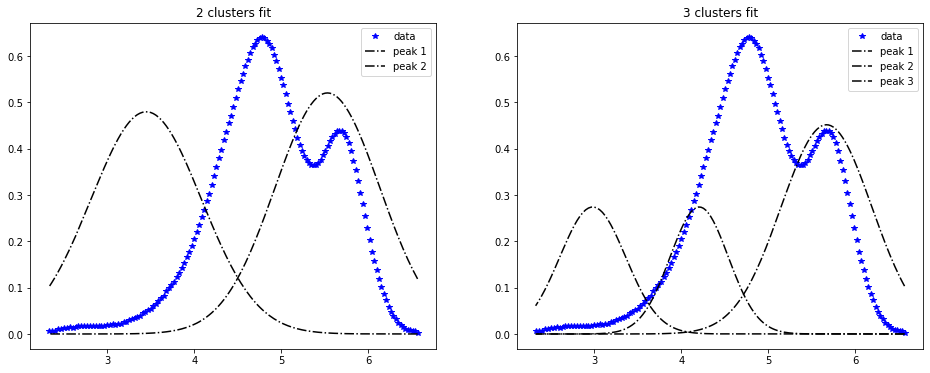

In [123]:
# the parameters for the 2 clusters fit
par2Clusters_peak1=fit2cluster[:3]
par2Clusters_peak2=fit2cluster[3:]
# parameters for3 clusters fit
par3Clusters_peak1=fit3cluster[:3]
par3Clusters_peak2=fit3cluster[3:6]
par3Clusters_peak3=fit3cluster[6:]

fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(x,y,'b*')
ax[0].plot(x,_1gaussian(x,*par2Clusters_peak1),'k-.')
ax[0].plot(x,_1gaussian(x,*par2Clusters_peak2),'k-.')
ax[0].set_title('2 clusters fit')
ax[0].legend(['data','peak 1','peak 2'])
ax[1].plot(x,y,'b*')
ax[1].plot(x,_1gaussian(x,*par3Clusters_peak1),'k-.')
ax[1].plot(x,_1gaussian(x,*par3Clusters_peak2),'k-.')
ax[1].plot(x,_1gaussian(x,*par3Clusters_peak3),'k-.')
ax[1].set_title('3 clusters fit')
ax[1].legend(['data','peak 1','peak 2','peak 3'])
plt.show()

### Approach 2
Using the GMM output, as an input for curve fitting using scipy.optimize

Using value for 2 peaks did trow an error and the values for 3 peaks is not really as expected if you compare with those I obtained using a paid software.

In [124]:
# defining a mixture of gaussian to be used for fitting
def _2gaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2):
    """A mixture of 2 gaussian"""
    return amp1*(np.exp(-(x_array-cen1)**2/(2*sigma1**2))) + amp2*(np.exp(-(x_array-cen2)**2/(2*sigma2**2)))
 
def _3gaussian(x_array, amp1,cen1,sigma1, amp2,cen2,sigma2, amp3,cen3,sigma3):
    """A mixture of 3 gaussian"""
    return amp1*(np.exp(-(x_array-cen1)**2/(2*sigma1**2))) + amp2*(np.exp(-(x_array-cen2)**2/(2*sigma2**2)))+\
            amp3*(np.exp(-(x_array-cen3)**2/(2*sigma3**2)))
    

def curvefit2Gauss(x_raw, y_raw, parameters):
    """Perform a curve fitting on mixture of 2 gaussian"""
    popt_gauss, pcov_gauss = curve_fit(_2gaussian, x_raw, y_raw, p0=parameters)
    perr_gauss = np.sqrt(np.diag(pcov_gauss))
    pars_1 = popt_gauss[0:3]; pars_2 = popt_gauss[3:6]
    peak_1 = _1gaussian(x_raw, *pars_1)
    peak_2 = _1gaussian(x_raw, *pars_2)  
    peaks = [peak_1,peak_2]
    peak_sum = peak_1 + peak_2 
    return peaks,peak_sum

def curvefit3Gauss(x_raw, y_raw, parameters):
    """Perform curve fitting on mixture of 3 gaussian"""
    popt_gauss, pcov_gauss = curve_fit(_3gaussian, x_raw, y_raw, p0=parameters)
    perr_gauss = np.sqrt(np.diag(pcov_gauss))
    pars_1 = popt_gauss[0:3]; pars_2 = popt_gauss[3:6]; pars_3 = popt_gauss[6:9]
    peak_1 = _1gaussian(x_raw, *pars_1)
    peak_2 = _1gaussian(x_raw, *pars_2)  
    peak_3 = _1gaussian(x_raw, *pars_3) 
    peaks = [peak_1,peak_2,peak_3]
    peak_sum = peak_1 + peak_2 + peak_3 
    return peaks, peak_sum


In [125]:
#_2peaks,_2peakSum = curvefit2Gauss(x,y,fit2cluster)
_3peaks,_3peakSum = curvefit3Gauss(x,y,fit3cluster)

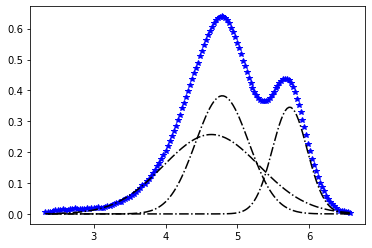

In [126]:
plt.plot(x,y,'b*',label='data')
plt.plot(x,_3peaks[0],'k-.',label='peak 1')
plt.plot(x,_3peaks[1],'k-.',label='peak 1')
plt.plot(x,_3peaks[2],'k-.',label='peak 1')
plt.show()

output obtained from paid software for comparison

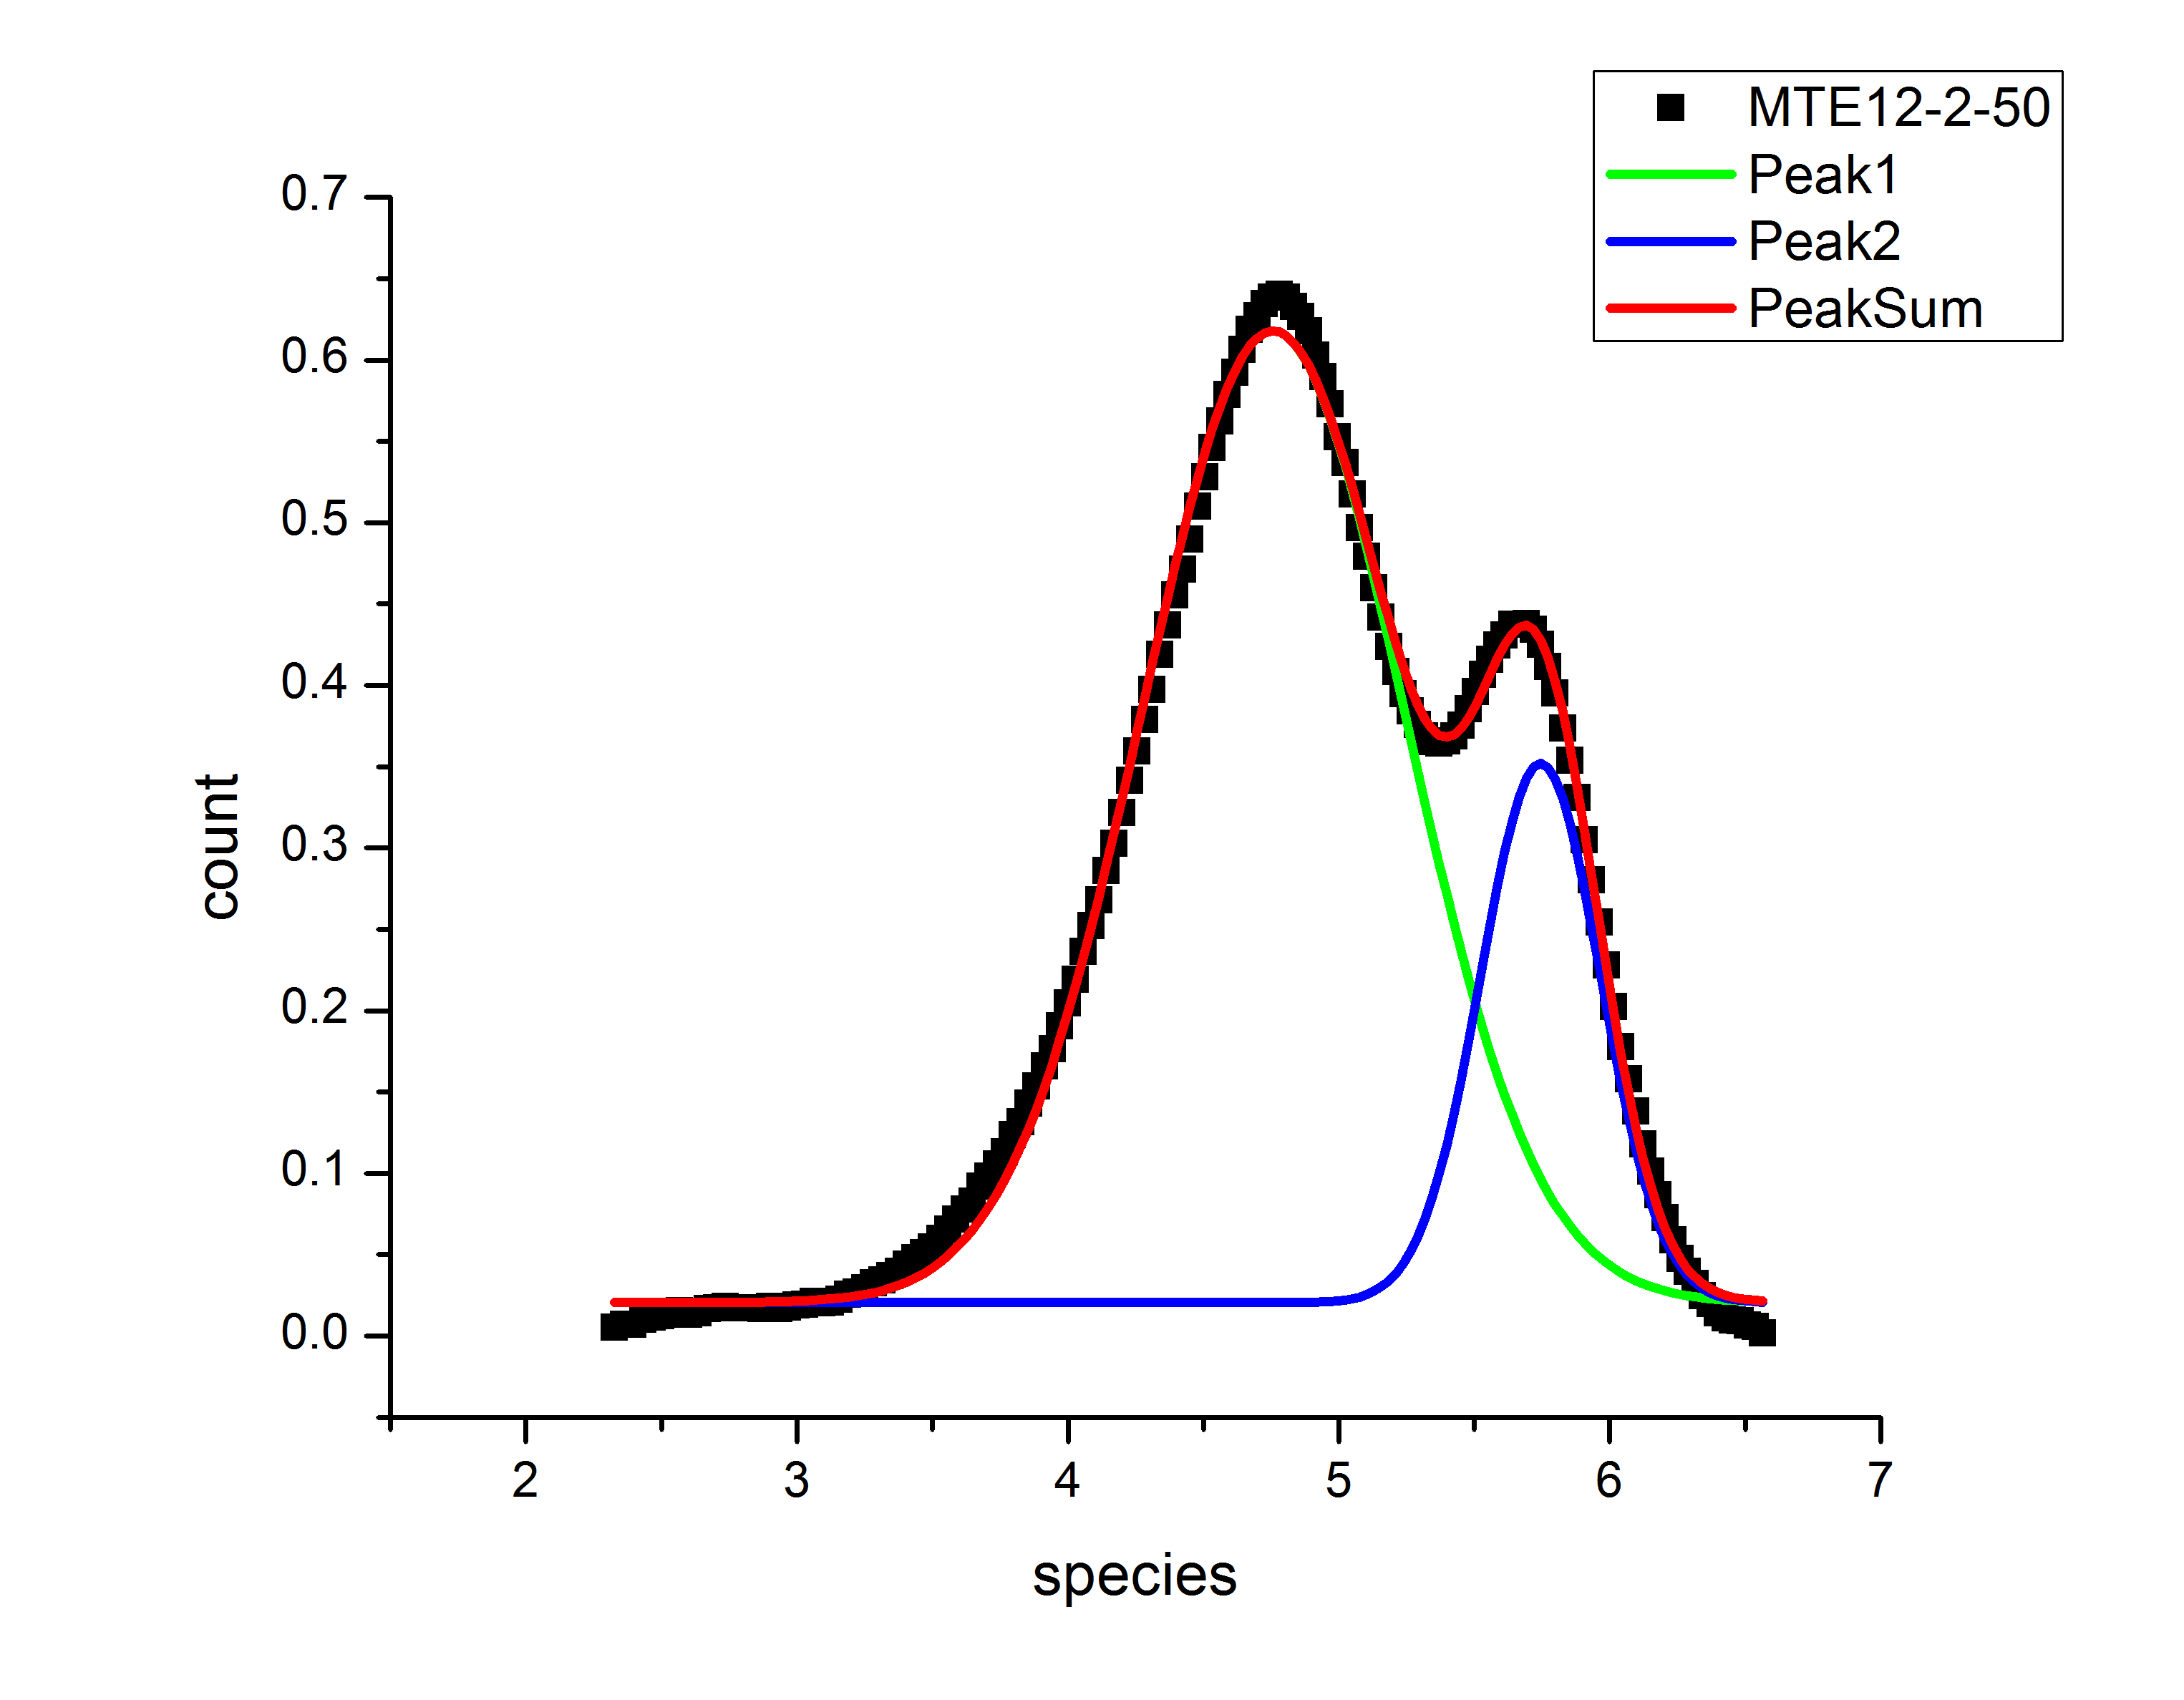

In [127]:
Image('origineplot.png',width=400,height=400)